# **FFDNet for SAR despeckling**

Main reference: Zhang, K., Zuo, W., & Zhang, L. (2018). FFDNet: Toward a fast and flexible solution for CNN-based image denoising [link](https://arxiv.org/abs/1710.04026).

In [1]:
import numpy as np
import torch
from PIL import Image
import os
import sys
from google.colab import drive
from importlib import reload
drive.mount('/content/drive/',force_remount=True)
#Go to the place with the Dataset in Google Drive
os.chdir('/content/drive/My Drive/FFDNet/code') 
sys.path.append('/content/drive/My Drive/FFDNet/code')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## Define data loaders and training configuration

In [0]:
from torch.utils.data import DataLoader
from dataloading import MyIterableDataset, modality_amplitude, modality_log_intensity, NoiseInjector
from FFDNet import *
from lossfunctions import *
from train_eval_routine import train_model, eval

############################
## Training configuration ##
############################
L = 1
modality = modality_amplitude
noise2noise = False
NI = NoiseInjector(L)
#name='amplitude_l1_noisy_noisy_w7'
name='test'
loss = amplitude_l1_loss
normalize = (loss == noise2noise_log_intensity_speckle_loss)
std_from_groundtruth_train = False
std_from_groundtruth_test = False
window_size = 7
const_sigma = False


#################
## Dataloaders ##
#################
nb_test_images = 100
np.random.seed(42)
lower_x_test = np.random.rand(nb_test_images)
lower_y_test = np.random.rand(nb_test_images)
# Image paths
# Necessary to always have the same order
img_train_list = ['../data/Training/ramb.npy', '../data/Training/limagne.npy', '../data/Training/lely.npy', '../data/Training/marais2.npy', '../data/Training/saclay.npy', '../data/Training/risoul.npy', '../data/Training/marais1.npy']
img_test_list = ['../data/Test/ramb.npy', '../data/Test/limagne.npy', '../data/Test/lely.npy', '../data/Test/marais2.npy', '../data/Test/saclay.npy', '../data/Test/risoul.npy', '../data/Test/marais1.npy']
img_real_list = ['../data/Real_images/lely_10.npy','../data/Real_images/lely_11.npy','../data/Real_images/limagne_10.npy','../data/Real_images/limagne_20.npy','../data/Real_images/marais1_10.npy','../data/Real_images/marais1_11.npy','../data/Real_images/marais2_10.npy','../data/Real_images/marais2_11.npy']

train_dataset = MyIterableDataset(img_train_list, 
                                  modality=modality,
                                  noise2noise=noise2noise,
                                  crop_shape=(250,250),
                                  transform=NI,
                                  std_from_ground_truth = std_from_groundtruth_train,
                                  window_size=window_size, const_sigma = const_sigma,
                                  normalize=normalize)

test_dataset = MyIterableDataset(img_test_list, 
                                 modality=modality,
                                 noise2noise=noise2noise,
                                 crop_shape=(250,250), 
                                 transform=NI, 
                                 train=False,
                                 lower_x_test = lower_x_test,
                                 lower_y_test = lower_y_test,
                                 nb_test_images = nb_test_images,
                                 std_from_ground_truth = std_from_groundtruth_test,
                                 window_size=window_size, const_sigma = const_sigma,
                                 normalize=normalize)
dl_train = DataLoader(train_dataset, batch_size = 1)
dl_test = DataLoader(test_dataset, batch_size = 1)



## Do a training

In [0]:
torch.cuda.empty_cache()
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

psnr_train, loss_train, psnr_test, loss_test = train_model(dl_train, 
                                                        dl_test,
                                                        criterion=loss,
                                                        epochs=300,
                                                        name=name)
psnr_train = np.array(psnr_train)
loss_train = np.array(loss_train)
psnr_test = np.array(psnr_test)
loss_test = np.array(loss_test)
np.save(name+'psnr_train.npy', np.array(psnr_train))
np.save(name+'loss_train.npy', np.array(loss_train))
np.save(name+'psnr_test.npy', np.array(psnr_test))
np.save(name+'loss_test.npy', np.array(loss_test))

## Visualize learning curves

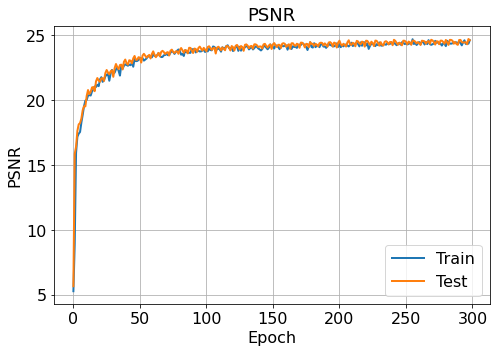

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.plot(range(len(psnr_train[1:])), psnr_train[1:], label='Train', linewidth=2)
ax.plot(range(len(psnr_test[1:])), psnr_test[1:], label='Test', linewidth=2)
ax.set_title('PSNR',fontsize=18)
ax.set_xlabel('Epoch',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel('PSNR',fontsize=16)
ax.legend(fontsize=16)
ax.grid()
fig.tight_layout()
fig.show()

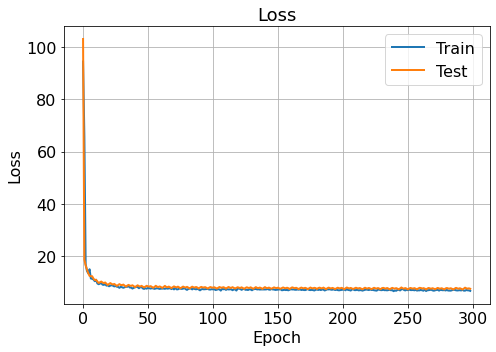

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.plot(range(len(loss_train[1:])), loss_train[1:], label='Train', linewidth=2)
ax.plot(range(len(loss_test[1:])), loss_test[1:], label='Test', linewidth=2)
ax.set_title('Loss',fontsize=18)
ax.set_xlabel('Epoch',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel('Loss',fontsize=16)
ax.legend(fontsize=16)
ax.grid()
fig.tight_layout()
fig.show()

## Denoise and save all test images

In [3]:
###############################
## Data loader configuration ##
###############################
name='amplitude_l1_noisy_noisy_w7'
img_save_path_root = "../data/Image_Database"
img_directory = name
loss = amplitude_l1_loss
normalize = (loss == noise2noise_log_intensity_speckle_loss)
modality = modality_amplitude
noise2noise = False
std_from_groundtruth_test = False
window_size = 7
const_sigma = False
normalize = name=='noise2noise_log_intensity_speckle_loss'

test_dataset = MyIterableDataset(img_test_list, 
                                 modality=modality,
                                 noise2noise=noise2noise,
                                 crop_shape=(250,250), 
                                 transform=NI, 
                                 train=False,
                                 lower_x_test = lower_x_test, 
                                 lower_y_test = lower_y_test, 
                                 nb_test_images = nb_test_images,
                                 std_from_ground_truth = std_from_groundtruth_test,
                                 window_size=7, const_sigma = const_sigma, normalize=normalize)
test_dataset.order_restart()
dl_test = DataLoader(test_dataset, batch_size = 1)

####################
## Load the model ##
####################
model_net_test = FFDNet()
device_ids = [0]
model = nn.DataParallel(model_net_test, device_ids=device_ids).cuda()
ckpts_directory =  "../checkpoints/ckpts_{}".format(name)
checkpoint = torch.load(os.path.join(ckpts_directory,'ckpt_e296.pth'),map_location='cuda:0')
model.load_state_dict(checkpoint['state_dict'])
model.cuda()

#############################
## Denoise and save images ##
#############################
mean_psnr, mean_psnr_noisy, mean_loss_test, mean_ratio = eval(model, dl_test, loss, save_img_flag = False, save_path_root=img_save_path_root, directory=img_directory)

Test  PSNR Denoised : 24.2411071721714
Test  PSNR Noisy : 11.942371202775325
Test  Loss 7.786456108093262
Test  ratio: 0.9938512444496155
Test  ratio std: 0.9618683457374573


## Take a look at the images

Text(0.5, 1.0, 'Output')

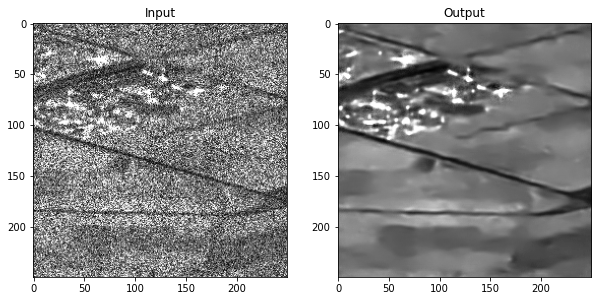

In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from imageio import imread

no = 2
name='amplitude_l1_noisy_noisy_w7'
img_save_path_root = "../data/Image_Database"
img_directory = name
path = os.path.join(img_save_path_root,img_directory)
input_path = os.path.join(path,str(no)+'_input.png')
output_path = os.path.join(path,str(no)+'_output.png')
input_img = imread(input_path)
output_img = imread(output_path)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))
axes[0].imshow(input_img, cmap='Greys_r')
axes[0].set_title('Input')
axes[1].imshow(output_img, cmap='Greys_r')
axes[1].set_title('Output')

# Real images
Evaluate the model on real images

In [0]:
from copy import copy
from grid_denoising import *

# Thresholds for img visualizations / storage
choices = {'marais1':190.92,
            'marais1_10':190.92,
            'marais1_11':190.92,
            'marais2': 168.49, 
            'marais2_10':168.49,
            'marais2_11':168.49,
            'saclay':470.92, 
            'lely':235.90, 
            'lely_10':235.90,
            'lely_11':235.90,
            'ramb':167.22,
            'risoul':306.94, 
            'limagne':178.43,
            'limagne_10':178.43,
            'limagne_20':178.43}
normalization_value = 470.0

#########################
## Model configuration ##
#########################
modality = modality_amplitude
model_name = 'amplitude_l1_noisy_noisy_w7'
loss = amplitude_l1_loss
normalize = (loss == noise2noise_log_intensity_speckle_loss)
std_from_groundtruth_test = False
window_size = 7
const_sigma = False
save_imgs = False

################
## Load model ##
################
ckpts_directory =  "../checkpoints/ckpts_{}".format(model_name)
checkpoint = torch.load(os.path.join(ckpts_directory,'ckpt_e296.pth'),map_location='cuda:0')
model_net_test = FFDNet()
device_ids = [0]
torch.cuda.empty_cache()
model = nn.DataParallel(model_net_test, device_ids=device_ids).cuda()
model.load_state_dict(checkpoint['state_dict'])

##############################
## Iterate over real images ##
##############################
output_dir=os.path.join('../data/Real_images_denoised',model_name)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
psnr_list = []
psnr_noisy_list = []
ratio_list = []
psnr_downsampled_list = []
psnr_noisy_downsampled_list = []
ratio_downsampled_list = []
for path in img_real_list:
    #### Read and prepare image
    picture_name = path.split("/")[-1].split(".")[0]
    print(picture_name)
    img = np.load(path)
    threshold = choices[picture_name]

    if model_name == 'noise2noise_log_intensity_speckle_loss':
        # normalization
        img = np.clip(img, 1e-10, normalization_value)/normalization_value
        # amplitude -> log_intensity
        img = 2*np.log(img)

    #### Denoise image
    denoised_img = denoise_image_grid(model, img, modality, window_size, const_sigma, grid_size=500)
    downsampled_img = copy(img[::2,::2])
    denoised_downsampled_img = denoise_image_grid(model, downsampled_img, modality, window_size, const_sigma, grid_size=250)

    #### Postprocess denoised image
    if model_name == 'noise2noise_log_intensity_speckle_loss':
        # log_intensity -> amplitude
        img = np.exp(0.5*img)
        denoised_img = np.exp(0.5*denoised_img)
        downsampled_img = np.exp(0.5*downsampled_img)
        denoised_downsampled_img = np.exp(0.5*denoised_downsampled_img)
        # denormalization
        img *= normalization_value
        denoised_img *= normalization_value
        downsampled_img *= normalization_value
        denoised_downsampled_img *= normalization_value
    
    #### statistics
    gt_path = '../data/Training/'+picture_name[:-3]+'.npy'
    gt_img = np.load(gt_path)
    gt_downsampled_img = gt_img[::2,::2]
    ratio = np.square(img) / np.square(denoised_img)
    ratio_list += list(ratio.flatten())
    psnrs, noisy_psnrs = get_grid_psnrs(img, denoised_img, gt_img, grid_size=500)
    psnr_list += psnrs
    psnr_noisy_list += noisy_psnrs
    ratio_downsampled = np.square(downsampled_img) / np.square(denoised_downsampled_img)
    ratio_downsampled_list += list(ratio_downsampled.flatten())
    psnrs_downsampled, noisy_psnr_downsampled = get_grid_psnrs(downsampled_img, denoised_downsampled_img, gt_downsampled_img, grid_size=250)
    psnr_downsampled_list += psnrs_downsampled
    psnr_noisy_downsampled_list += noisy_psnr_downsampled


    #### save imgs
    if save_imgs:
        output_img_file = os.path.join(output_dir,"{}_output.png".format(picture_name))
        denoised_img = denoised_img/threshold*255
        dimg = Image.fromarray(denoised_img.astype('float64')).convert('L')
        dimg.save(output_img_file)
        output_img_file = os.path.join(output_dir,"{}_output_downsampled.png".format(picture_name))
        dimg = denoised_downsampled_img/threshold*255
        dimg = Image.fromarray(dimg.astype('float64')).convert('L')
        dimg.save(output_img_file)

        ratio_img_file = os.path.join(output_dir,"{}_ratio.png".format(picture_name))
        thresh_calc = np.quantile(ratio.flatten(), .99)
        dim = np.clip(ratio,0,thresh_calc)
        dim = dim/thresh_calc *255
        dim = Image.fromarray(dim.astype('float64')).convert('L')
        dim.save(ratio_img_file)

#### Print performance summary
print('PSNR (noisy)',np.mean(psnr_noisy_list))
print('PSNR (denoised)',np.mean(psnr_list))
ratio_list = np.array(ratio_list)
ratio_list_filtered = ratio_list[ratio_list < np.quantile(ratio_list, 0.999)]
print('Ratio',np.mean(ratio_list_filtered))
print('PSRN (downsampled noisy)', np.mean(psnr_noisy_downsampled_list))
print('PSNR (downsampled denoised)', np.mean(psnr_downsampled_list))
ratio_downsampled_list = np.array(ratio_downsampled_list)
ratio_downsampled_list_filtered = ratio_downsampled_list[ratio_downsampled_list < np.quantile(ratio_downsampled_list, 0.999)]
print('Ratio (downsampled)',np.mean(ratio_downsampled_list_filtered))

lely_10
lely_11
limagne_10
limagne_20
marais1_10
marais1_11
marais2_10
marais2_11
PSNR (noisy) 9.661139770951564
PSNR (denoised) 16.796880234741604
Ratio 0.9825950007934153
PSRN (downsampled noisy) 9.656796478460262
PSNR (downsampled denoised) 17.729521038689498
Ratio (downsampled) 0.990339465311071


## External eval set
Evaluate the model on the external eval set (comparable to SAR-CNN and Noise2Noise U-Net)

In [0]:
from glob import glob
def eval_noisy_path_2_clean_path(noisy_path):
    picture_name = noisy_path.split("/")[-1].split("_")[0]
    path = '../data/project_FFDNet_eval/clean/'+picture_name+'.npy'
    return path
def eval_noisy_path_2_denoised_path(noisy_path, model_name):
    picture_name = noisy_path.split("/")[-1].split(".")[0]
    path = '../data/project_FFDNet_eval/denoised/'+model_name+'/'+picture_name+'.png'
    return path

# Thresholds
choices = {'marais1':190.92, 
            'marais2': 168.49, 
            'saclay':470.92, 
            'lely':235.90,
            'ramb':167.22,
            'risoul':306.94, 
            'limagne':178.43}
normalization_value = 470.0
save_imgs = False

#########################
## Model configuration ##
#########################
#model_name = 'noise2noise_log_intensity_speckle_loss'
model_name = 'amplitude_l1_noisy_noisy_w7'
normalize = (model_name == 'noise2noise_log_intensity_speckle_loss')
modality = modality_amplitude
window_size = 7
const_sigma = False

################
## Load Model ##
################
ckpts_directory =  "../checkpoints/ckpts_{}".format(model_name)
checkpoint = torch.load(os.path.join(ckpts_directory,'ckpt_e296.pth'),map_location='cuda:0')
model_net_test = FFDNet()
device_ids = [0]
torch.cuda.empty_cache()
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
model = nn.DataParallel(model_net_test, device_ids=device_ids).cuda()
model.load_state_dict(checkpoint['state_dict'])



###################################
## Iterate over external dataset ##
###################################
output_dir=os.path.join('../data/project_FFDNet_eval/denoised',model_name)
input_paths = glob('../data/project_FFDNet_eval/noisy/*.npy')
psnr_list = dict()
psnr_noisy_list = []
ratio_list = []

for path in input_paths:
    picture_name = path.split("/")[-1].split(".")[0]
    clean_path = eval_noisy_path_2_clean_path(path)
    denoised_dir = '../data/project_FFDNet_eval/denoised/'+model_name

    # Preprocessing
    img = np.load(path)
    if normalize:
        #normalization
        img = np.clip(img, 0.0, normalization_value)/normalization_value
        # amplitude -> log_intensity
        img = 2*np.log(img)
    threshold = choices[picture_name.split("_")[0]]

    denoised_img = denoise_image_grid(model, img, modality, window_size, const_sigma, 256)

    # Postprocessing
    if normalize:
        # log_intensity -> amplitude
        img = np.exp(0.5*img)
        denoised_img = np.exp(0.5*denoised_img)
        # denormalization
        img *= normalization_value
        denoised_img *= normalization_value
    
    # statistics
    gt_img = np.load(clean_path)
    ratio_list += list((np.square(img)/np.square(denoised_img)).flatten())
    psnrs, noisy_psnrs = get_grid_psnrs(img, denoised_img, gt_img, 256)
    picture_name = picture_name.split("_")[0]
    if picture_name not in psnr_list:
        psnr_list[picture_name] = []
    psnr_list[picture_name] += psnrs
    psnr_noisy_list += noisy_psnrs

    if save_imgs:
        output_img_file = os.path.join(output_dir,"{}_output.png".format(picture_name))
        np.save(os.path.join(denoised_dir,picture_name+'.npy'), denoised_img)
        denoised_img = denoised_img/threshold*255
        denoised_img = Image.fromarray(denoised_img.astype('float64')).convert('L')
        denoised_img.save(output_img_file)

print('PSNR (noisy)',np.mean(psnr_noisy_list))
psnrlists = []
for name, psnrs in psnr_list.items():
    print('PSNR (denoised)',name,np.mean(psnrs))
    psnrlists += psnrs
print('Total mean PSNR (denoised)', np.mean(psnrlists))
print('Ratio',np.mean(ratio_list))

PSNR (noisy) 12.1936409463428
PSNR (denoised) marais1 25.341238721474177
PSNR (denoised) limagne 23.873791736381225
PSNR (denoised) marais2 26.11155997491259
PSNR (denoised) ramb 23.589260133458055
PSNR (denoised) lely 22.69225608329648
PSNR (denoised) saclay 22.713269234843494
PSNR (denoised) risoul 30.226098512262343
Total mean PSNR (denoised) 24.935353485232618
Ratio 0.9952501388742714
